In [ ]:
!nvcc --version
!nvidia-smi
import torch
torch.__version__

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Thu May 16 16:57:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  7

'2.2.1+cu121'

In [1]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@5aeb252b194b93dc2879b4ac34bc51a31b5aee13'

  Cloning https://github.com/facebookresearch/detectron2.git (to revision 5aeb252b194b93dc2879b4ac34bc51a31b5aee13) to /tmp/pip-req-build-y32701_6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-y32701_6
  Running command git rev-parse -q --verify 'sha^5aeb252b194b93dc2879b4ac34bc51a31b5aee13'
  Running command git fetch -q https://github.com/facebookresearch/detectron2.git 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Running command git checkout -q 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.5 MB/s eta 

In [1]:
%cd /content/
!git clone https://github.com/DomMcOyle/TACO-expl.git
%cd /content/TACO-expl
!git checkout maskdino
!git pull origin maskdino
%cd /content/TACO-expl/MaskDINO
!pip install -r requirements.txt
%cd /content/TACO-expl/MaskDINO/maskdino/modeling/pixel_decoder/ops
!sh make.sh

/content
Cloning into 'TACO-expl'...
remote: Enumerating objects: 2338, done.
remote: Counting objects: 100% (2338/2338), done.
remote: Compressing objects: 100% (1124/1124), done.
remote: Total 2338 (delta 1226), reused 2258 (delta 1175), pack-reused 0
Receiving objects: 100% (2338/2338), 130.95 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (1226/1226), done.
/content/TACO-expl
Branch 'maskdino' set up to track remote branch 'maskdino' from 'origin'.
Switched to a new branch 'maskdino'
From https://github.com/DomMcOyle/TACO-expl
 * branch            maskdino   -> FETCH_HEAD
Already up to date.
/content/TACO-expl/MaskDINO
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 1.1 MB/s eta 0:00:00
/content/TACO-expl/MaskDINO/maskdino/modeling/pixel_decoder/ops
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Traceback (most recent call last):
  File "/content/TACO-expl/MaskDINO/maskdino/modeling/pixel_decoder/ops/setup.py", line 76, in <module>
    ext_modules=get_exten

In [2]:
from google.colab import drive
drive.mount("/content/MyDrive/", force_remount = True)

Mounted at /content/MyDrive/


In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
%cd /content/
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

/content


In [4]:
import sys
sys.path.append("/content/TACO-expl/MaskDINO")
!cd /content/TACO-expl/MaskDINO/
cfg_biggest_path = '/content/TACO-expl/MaskDINO/configs/coco/instance-segmentation/swin/maskdino_R50_bs16_50ep_4s_dowsample1_2048.yaml'
model_biggest_weights_url = 'https://github.com/IDEA-Research/detrex-storage/releases/download/maskdino-v0.1.0/maskdino_swinl_50ep_300q_hid2048_3sd1_instance_maskenhanced_mask52.3ap_box59.0ap.pth'

cfg_smallest_path = '/content/TACO-expl/MaskDINO/configs/coco/instance-segmentation/maskdino_R50_bs16_50ep_3s.yaml'
model_smallest_weight_url = 'https://github.com/IDEA-Research/detrex-storage/releases/download/maskdino-v0.1.0/maskdino_r50_50ep_300q_hid1024_3sd1_instance_maskenhanced_mask46.1ap_box51.5ap.pth'

In [6]:
sys.path.append('/content/TACO-expl/MaskDINO/maskdino/')
from config import add_maskdino_config
%cd /content/TACO-expl/MaskDINO/maskdino/
from detectron2.projects.deeplab import add_deeplab_config
#from maskdino import MaskDINO

def setup_cfg(cfg_path, weights_url):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_maskdino_config(cfg)
    cfg.merge_from_file(cfg_path)
    #cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    #cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.WEIGHTS = weights_url
    cfg.freeze()
    return cfg

cfg_alt_dino = setup_cfg(cfg_smallest_path, model_smallest_weight_url)
cfg_modified = cfg_alt_dino.copy()
#print(cfg_modified["MODEL"])

/content/TACO-expl/MaskDINO/maskdino


In [7]:
%cd /content/TACO-expl/
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import os.path
import json
import argparse
import numpy as np
import random
import datetime as dt
import copy
import torch.nn as nn
from sklearn.model_selection import train_test_split
from pathlib import Path

import torch
import math
import torch.utils.data
from torch.utils.data import DataLoader
from pycocotools import mask as coco_mask


from torchvision.ops import RoIAlign
from HDDETR.datasets.torchvision_datasets.coco import CocoDetection as TvCocoDetection # from torchvision.datasets import CocoDetection as TvCocoDetection
                                                                                       # the right above import import does not work bc of attribute definitions
import HDDETR.datasets.transforms as T #from torchvision import transforms as T # this import does not contain the randomselect method
import HDDETR.util.misc as mutils

/content/TACO-expl


In [8]:
DEFAULT_RANDOM_SEED = 42
# basic random seed
def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
# torch random seed
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# combine
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

seedEverything()

In [9]:
keep_categories = ["Bottle", "Bottle cap", "Can", "Cigarette", "Cup",
                   "Lid", "Plastic bag & wrapper", "Pop tab", "Straw"]

def create_map(original, keep_supercategories):
  class_map = {}
  for cat in original:
    if cat["supercategory"] in keep_supercategories:
      class_map[cat["name"]] = cat["supercategory"]
    else:
      class_map[cat["name"]] = "Other"
  return class_map

def replace_dataset_classes(dataset, class_map):
      """ Replaces classes of dataset based on a dictionary"""
      class_new_names = list(set(class_map.values()))
      class_new_names.sort()
      class_originals = copy.deepcopy(dataset['categories'])
      dataset['categories'] = []
      class_ids_map = {}  # map from old id to new id

      # Assign background id 0
      has_background = False
      if 'Background' in class_new_names:
          if class_new_names.index('Background') != 0:
              class_new_names.remove('Background')
              class_new_names.insert(0, 'Background')
          has_background = True

      # Replace categories
      for id_new, class_new_name in enumerate(class_new_names):
          # Make sure id:0 is reserved for background
          id_rectified = id_new
          if not has_background:
              id_rectified += 1

          category = {
              'supercategory': '',
              'id': id_rectified,  # Background has id=0
              'name': class_new_name,
          }
          dataset['categories'].append(category)
          # Map class names
          for class_original in class_originals:
              if class_map[class_original['name']] == class_new_name:
                  class_ids_map[class_original['id']] = id_rectified

      # Update annotations category id tag
      for ann in dataset['annotations']:
          ann['category_id'] = class_ids_map[ann['category_id']]

In [10]:
with open("/content/TACO-expl/data/annotations.json", "r") as f: #"/content/TACO/data/annotations.json"
    dataset = json.loads(f.read())

class_map = create_map(dataset["categories"], keep_categories)
replace_dataset_classes(dataset, class_map)
dataset["categories"]

[{'supercategory': '', 'id': 1, 'name': 'Bottle'},
 {'supercategory': '', 'id': 2, 'name': 'Bottle cap'},
 {'supercategory': '', 'id': 3, 'name': 'Can'},
 {'supercategory': '', 'id': 4, 'name': 'Cigarette'},
 {'supercategory': '', 'id': 5, 'name': 'Cup'},
 {'supercategory': '', 'id': 6, 'name': 'Lid'},
 {'supercategory': '', 'id': 7, 'name': 'Other'},
 {'supercategory': '', 'id': 8, 'name': 'Plastic bag & wrapper'},
 {'supercategory': '', 'id': 9, 'name': 'Pop tab'},
 {'supercategory': '', 'id': 10, 'name': 'Straw'}]

In [11]:
classes = [elem["name"] for elem in dataset["categories"]]
print(classes)

['Bottle', 'Bottle cap', 'Can', 'Cigarette', 'Cup', 'Lid', 'Other', 'Plastic bag & wrapper', 'Pop tab', 'Straw']


In [12]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

help(register_coco_instances)

Help on function register_coco_instances in module detectron2.data.datasets.coco:

register_coco_instances(name, metadata, json_file, image_root)
    Register a dataset in COCO's json annotation format for
    instance detection, instance segmentation and keypoint detection.
    (i.e., Type 1 and 2 in http://cocodataset.org/#format-data.
    `instances*.json` and `person_keypoints*.json` in the dataset).
    
    This is an example of how to register a new dataset.
    You can do something similar to this function, to register new datasets.
    
    Args:
        name (str): the name that identifies a dataset, e.g. "coco_2014_train".
        metadata (dict): extra metadata associated with this dataset.  You can
            leave it as an empty dict.
        json_file (str): path to the json instance annotation file.
        image_root (str or path-like): directory which contains all the images.



In [13]:
train_annotation_file = '/content/TACO-expl/data/annotations_off_0_train.json'
val_annotation_file = '/content/TACO-expl/data/annotations_off_0_val.json'

img_dir = '/content/MyDrive/MyDrive/official/'

register_coco_instances("TACO_train", {}, train_annotation_file, img_dir)
MetadataCatalog.get("TACO_train").set(thing_classes = classes)
dataset_dicts_train = DatasetCatalog.get("TACO_train")

register_coco_instances("TACO_val", {}, val_annotation_file, img_dir)
MetadataCatalog.get("TACO_val").set(thing_classes = classes)
dataset_dicts_val = DatasetCatalog.get("TACO_val")

[05/17 09:01:15 d2.data.datasets.coco]: Loaded 1200 images in COCO format from /content/TACO-expl/data/annotations_off_0_train.json
[05/17 09:01:15 d2.data.datasets.coco]: Loaded 150 images in COCO format from /content/TACO-expl/data/annotations_off_0_val.json


In [14]:
import json

with open(val_annotation_file, "r") as f:
  val_annotations = json.load(f)

print(val_annotations.keys())

dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


In [ ]:
first_img = val_annotations["images"][0]
first_ann = val_annotations["annotations"][0]

print(first_img)
print(first_ann)

{'id': 899, 'width': 3264, 'height': 2448, 'file_name': 'batch_4/000023.JPG', 'license': None, 'flickr_url': 'https://farm66.staticflickr.com/65535/47803892332_5218b74150_o.png', 'coco_url': None, 'date_captured': None, 'flickr_640_url': 'https://farm66.staticflickr.com/65535/47803892332_f552fb65c7_z.jpg'}
{'id': 47, 'image_id': 15, 'category_id': 1, 'segmentation': [[249.0, 1458.0, 236.0, 1360.0, 222.0, 1247.0, 150.0, 784.0, 150.0, 747.0, 157.0, 712.0, 172.0, 675.0, 184.0, 656.0, 205.0, 632.0, 238.0, 603.0, 263.0, 589.0, 299.0, 575.0, 312.0, 570.0, 322.0, 568.0, 324.0, 567.0, 323.0, 538.0, 319.0, 497.0, 314.0, 432.0, 307.0, 362.0, 307.0, 354.0, 313.0, 346.0, 317.0, 343.0, 328.0, 338.0, 345.0, 333.0, 355.0, 330.0, 363.0, 328.0, 371.0, 334.0, 386.0, 332.0, 404.0, 330.0, 421.0, 330.0, 450.0, 332.0, 476.0, 335.0, 486.0, 338.0, 489.0, 337.0, 493.0, 335.0, 501.0, 337.0, 509.0, 341.0, 518.0, 346.0, 527.0, 351.0, 531.0, 359.0, 531.0, 369.0, 532.0, 400.0, 533.0, 429.0, 538.0, 526.0, 541.0, 566

In [ ]:
!mkdir /content/resized_validation/

In [15]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import itertools

def visualize_mask(mask):
    plt.figure(figsize=(8, 8))
    plt.imshow(mask)
    #plt.axis('off')
    plt.show()

def flatten(aList):
  t = []
  for i in aList:
    if not isinstance(i, list):
      t.append(i)
    else:
      t.extend(flatten(i))
  return t

def mask_to_polygon(mask):
    # Find contours
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for contour in contours:
        # Convert polygon to list of coordinates
        polygon = contour.squeeze().astype(float).tolist()
        polygons.append(polygon)
    #polygons = flatten(polygons)
    return polygons

def visualize_polygons(polygons):
    plt.figure(figsize=(8, 8))
    for polygon in polygons:
        polygon = np.array(polygon)
        plt.plot(polygon[:, 0], polygon[:, 1], color='red', linewidth=2)
    plt.axis('off')
    plt.show()

"""
def group_coords_poly(ungrouped_poly):
  to_return = []
  for inner_list in ungrouped_poly:
    to_append = [[inner_list[i], inner_list[i+1]] for i in range(0, len(inner_list), 2)]
    to_return.append(to_append)
  return to_return
"""
def group_coords_poly(ungrouped_poly):
  ung_poly = ungrouped_poly.copy()
  ung_poly = flatten(ung_poly)
  to_return = [[[ung_poly[i], ung_poly[i+1]] for i in range(0, len(ung_poly), 2)]]
  return to_return

def ungroup_coords_poly(grouped_poly):
  #to_return = [[elem for pair_inner_list in inner_list for elem in pair_inner_list] for inner_list in grouped_poly]
  to_return = [flatten(grouped_poly)]
  return to_return

#some_ann = [[2152.0, 1374.0, 2206.0, 1375.0, 2239.0, 1366.0], [2262.0, 1358.0, 2275.0, 1342.0, 2270.0, 1323.0, 2259.0, 1312.0, 2249.0, 1308.0, 2251.0, 1291.0, 2236.0, 1270.0, 2218.0, 1259.0, 2191.0, 1254.0, 2149.0, 1256.0, 2125.0, 1259.0, 2109.0, 1272.0, 2098.0, 1285.0, 2093.0, 1294.0, 2090.0, 1307.0, 2080.0, 1314.0, 2069.0, 1324.0, 2073.0, 1347.0, 2095.0, 1363.0, 2122.0, 1370.0, 2152.0, 1374.0]]
#to_print = group_coords_poly(some_ann)
#print(to_print)
#print(ungroup_coords_poly(to_print))

In [45]:
!mkdir /content/res_val

In [21]:
val_annotations.keys()
resized_val_json = {}
resized_val_json['info'] = val_annotations['info']
resized_val_json['scene_annotations'] = val_annotations['scene_annotations']
resized_val_json['licenses'] = val_annotations['licenses']
resized_val_json['categories'] = val_annotations['categories']
resized_val_json['scene_categories'] = val_annotations['scene_categories']

In [24]:
val_annotations['images'][0]

{'id': 899,
 'width': 3264,
 'height': 2448,
 'file_name': 'batch_4/000023.JPG',
 'license': None,
 'flickr_url': 'https://farm66.staticflickr.com/65535/47803892332_5218b74150_o.png',
 'coco_url': None,
 'date_captured': None,
 'flickr_640_url': 'https://farm66.staticflickr.com/65535/47803892332_f552fb65c7_z.jpg'}

In [27]:
import numpy as np
from itertools import groupby

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [56]:
from detectron2.data.transforms.augmentation_impl import ResizeShortestEdge
from detectron2.data.transforms import ResizeTransform
from PIL import Image
from pycocotools import mask as coco_mask
from skimage import measure

def check_rotation_and_alpha(image):
        img_shape = np.shape(image)

        # load metadata
        exif = image.getexif()
        if exif:
            exif = dict(exif.items())
            # Rotate portrait images if necessary (274 is the orientation tag code)
            if 274 in exif:
                if exif[274] == 3:
                    image = image.rotate(180, expand=True)
                if exif[274] == 6:
                    image = image.rotate(270, expand=True)
                if exif[274] == 8:
                    image = image.rotate(90, expand=True)

        # If has an alpha channel, remove it for consistency
        if img_shape[-1] == 4:
            image = image[..., :3]
        return image



#import pycocotools.mask as mask_util

resize_obj_func = ResizeShortestEdge(800,
                                  1333,
                                  sample_style = "choice")

res_imgs_json_path = "/content/resized_taco_validation.json"
where_save = "/content/resized_validation/"
res_imgs_list = []
res_annotation_list = []
time_to_break = False
for img_meta in val_annotations["images"]:
  if time_to_break:
    break
  res_img_dict = img_meta.copy()
  id = img_meta["id"]
  height = img_meta["height"]
  width = img_meta["width"]
  print(height, width)
  img_path = img_meta["file_name"]
  sub_dir = img_path.split("/")[0]
  folder = os.path.join("/content/res_val/",sub_dir)
  if not os.path.exists(folder):
    os.mkdir(folder)

  new_h, new_w = ResizeShortestEdge.get_output_shape(height, width, 800, 1333)
  res_img_dict.update({"height": height, "width": width})
  res_imgs_list.append(res_img_dict)

  trans_func = ResizeTransform(height, width, new_h, new_w, Image.BILINEAR)

  img = Image.open(os.path.join("/content/MyDrive/MyDrive/official", img_path))
  img = check_rotation_and_alpha(img)
  img = np.array(img)
  print(img.shape)
  res_img = trans_func.apply_image(img)
  res_pil = Image.fromarray(res_img.astype(np.uint8))
  res_pil.save(os.path.join(folder, img_path.split("/")[1]))

  for annotation in val_annotations["annotations"]:
    if annotation["image_id"] == id:
      res_segm_dict = annotation.copy()
      rles = coco_mask.frPyObjects(annotation["segmentation"], height, width)
      rle = coco_mask.merge(rles)
      mask = coco_mask.decode(rle)

      res_mask = trans_func.apply_segmentation(mask)
      res_mask = np.asfortranarray(np.squeeze(res_mask))
      uncomp = binary_mask_to_rle(res_mask)


      encoded_ground_truth = coco_mask.encode(res_mask)
      ground_truth_area = coco_mask.area(encoded_ground_truth)
      ground_truth_bounding_box = coco_mask.toBbox(encoded_ground_truth)

      res_segm_dict.update({"segmentation": uncomp,
                            "area": ground_truth_area,
                            "bbox": ground_truth_bounding_box})
      res_annotation_list.append(res_segm_dict)
  if time_to_break:
    break


2448 3264
(2448, 3264, 3)
3264 2448
(3264, 2448, 3)
4032 3024
(4032, 3024, 3)
4160 3120
(4160, 3120, 3)
3264 2448
(3264, 2448, 3)
2448 3264
(2448, 3264, 3)
3264 2448
(3264, 2448, 3)
4160 3120
(4160, 3120, 3)
3264 2448
(3264, 2448, 3)
3264 2448
(3264, 2448, 3)
3264 2448
(3264, 2448, 3)
2049 1537
(2049, 1537, 3)
3264 2448
(3264, 2448, 3)
4128 3096
(4128, 3096, 3)
3264 2448
(3264, 2448, 3)
4000 1824
(4000, 1824, 3)
4128 2322
(4128, 2322, 3)
3264 2448
(3264, 2448, 3)
4160 3120
(4160, 3120, 3)
4032 3024
(4032, 3024, 3)
4160 3120
(4160, 3120, 3)
3968 2976
(3968, 2976, 3)
3264 2448
(3264, 2448, 3)
4160 3120
(4160, 3120, 3)
2448 3264
(2448, 3264, 3)
4032 3024
(4032, 3024, 3)
3120 4160
(3120, 4160, 3)
2448 3264
(2448, 3264, 3)
2448 3264
(2448, 3264, 3)
4032 3024
(4032, 3024, 3)
3264 2448
(3264, 2448, 3)
2448 3264
(2448, 3264, 3)
3264 2448
(3264, 2448, 3)
5312 2988
(5312, 2988, 3)
2448 3264
(2448, 3264, 3)
2448 3264
(2448, 3264, 3)
2448 3264
(2448, 3264, 3)
2448 3264
(2448, 3264, 3)
3264 2448
(3

In [57]:
!zip -r /content/file.zip /content/res_val

updating: content/res_val/ (stored 0%)
updating: content/res_val/batch_3/ (stored 0%)
updating: content/res_val/batch_3/IMG_5049.JPG (deflated 2%)
updating: content/res_val/batch_3/IMG_4939.JPG (deflated 1%)
updating: content/res_val/batch_3/IMG_4950.JPG (deflated 0%)
updating: content/res_val/batch_3/IMG_4966.JPG (deflated 0%)
updating: content/res_val/batch_3/IMG_4913.JPG (deflated 0%)
updating: content/res_val/batch_3/IMG_4978.JPG (deflated 0%)
updating: content/res_val/batch_3/IMG_4992.JPG (deflated 0%)
updating: content/res_val/batch_3/IMG_4854.JPG (deflated 0%)
updating: content/res_val/batch_3/IMG_4878.JPG (deflated 2%)
updating: content/res_val/batch_9/ (stored 0%)
updating: content/res_val/batch_9/000066.jpg (deflated 0%)
updating: content/res_val/batch_9/000030.jpg (deflated 0%)
updating: content/res_val/batch_9/000090.jpg (deflated 0%)
updating: content/res_val/batch_9/000052.jpg (deflated 0%)
updating: content/res_val/batch_9/000032.jpg (deflated 0%)
updating: content/res_v

In [ ]:
resized_val_json["images"] = res_imgs_list
resized_val_json["annotations"] = res_annotation_list

In [34]:
resized_ann_path = '/content/TACO-expl/data/annotations_off_0_resval.json'
with open(resized_ann_path, "w") as f:
  json.dump(resized_val_json, f)

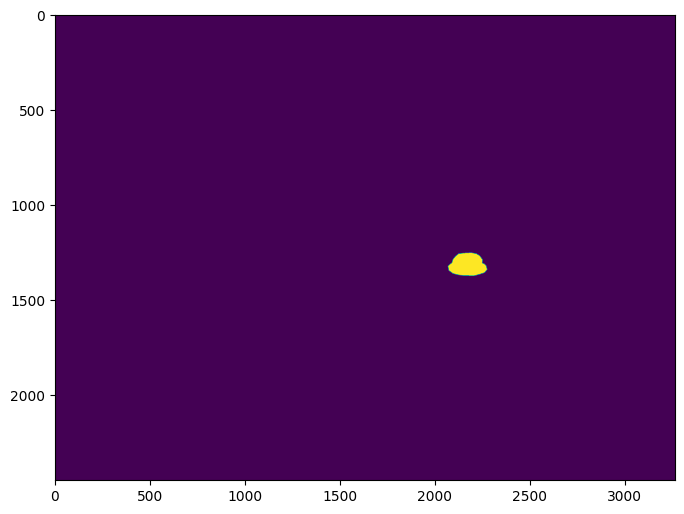

In [38]:
visualize_mask(mask)

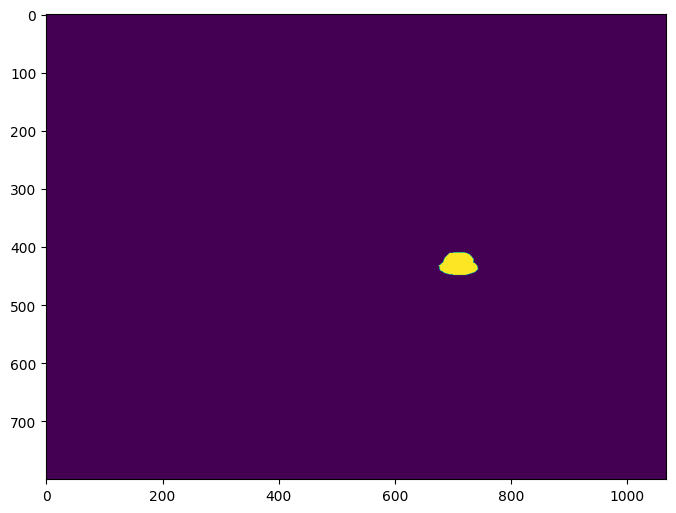

In [39]:
visualize_mask(res_mask)

In [41]:
segm = coco_mask.frPyObjects(uncomp, *uncomp["size"])

In [42]:
dec_mask = coco_mask.decode(segm)

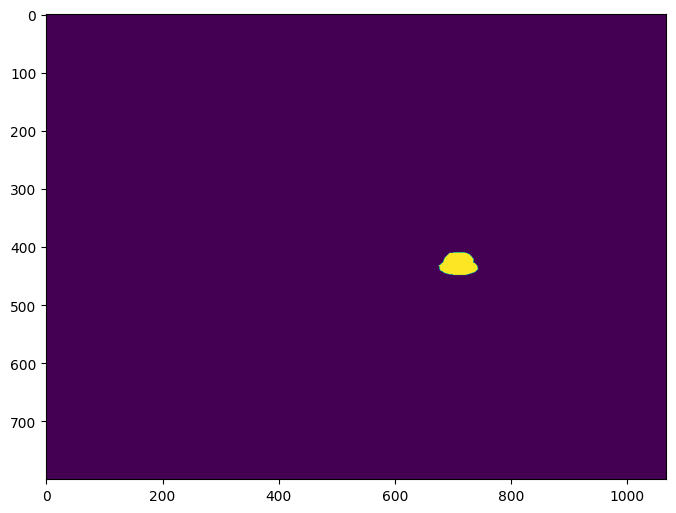

In [43]:
visualize_mask(dec_mask)

In [44]:
(dec_mask == res_mask).all()

True

In [ ]:
uncomp = binary_mask_to_rle(res_mask)

In [ ]:
segmask = coco_mask.decode(segm)

In [ ]:
segmask.shape

(1067, 800)

In [ ]:
(segmask == res_mask).all()

True

In [ ]:
decoded2 = coco_mask.decode(encoded_ground_truth)

In [ ]:
(decoded2 == res_mask).all()

True

In [36]:
print(len(res_imgs_list))

150
